# Project Overview

This notebook is part of the solution for the competition on Signate (Competition: [採血データを使った心不全予測](https://signate.jp/competitions/1394)). Competition id is 1394. The goal of this project is to analyze the provided dataset and build a predictive model to solve the problem. The notebook will document the steps taken in the data exploration, preprocessing, model building, and evaluation process.

The code is written in Python using popular libraries such as Pandas, Scikit-learn, and Matplotlib.

---

このノートブックは、Signateのコンペティションの解法の一部である。プロジェクトの目標は、提供されたデータセットを解析し、問題を解決する予測モデルを構築すること。このノートブックでは、データ探索、前処理、モデル構築、評価プロセスの各ステップを記録する。

コードは、Pandas、Scikit-learn、Matplotlibなどの人気ライブラリを使用して記述されている。

# Prepairing dataset

In [2]:
#installing signate API to download dataset
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f6d1623fb7a44196d0bb800278377edd5b107bf4e4d89095f327264832d9fe7f
  Stored in directory: /Users/user/Library/Caches/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [6]:
#checking files
!signate files --competition-id=1394

  fileId  name                   title                               size  updated_at
--------  ---------------------  --------------------------------  ------  -------------------
    1868  train.csv              学習用データ                       60478  2021-02-22 13:49:13
    1869  test.csv               評価用データ                       58247  2021-02-22 13:49:24
    1870  sample_submission.csv  サンプルサブミッション用ファイル    6436  2021-02-22 13:49:37


In [7]:
#Downloading files
!signate download --competition-id=1394

sample_submission.csv
100% [............................................................] 6436 / 6436
test.csv
100% [..........................................................] 58247 / 58247
train.csv
100% [..........................................................] 60478 / 60478

Download completed.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the training and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Display the first few rows to check the data
print("Train Data:")
train_df.head()

Train Data:


,id,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,target
0,0,56,1,5882,0,38,0,185315.0104,0.844417,134,1,0,10,1
1,3,50,0,1767,1,35,0,371620.3666,0.837448,136,0,0,187,1
2,7,41,0,250,1,30,0,372810.2084,0.819996,139,1,0,29,1
3,11,47,0,582,1,20,0,185780.6482,0.870314,137,0,0,43,0
4,12,60,0,80,0,25,0,265096.3999,0.828112,136,1,0,213,0


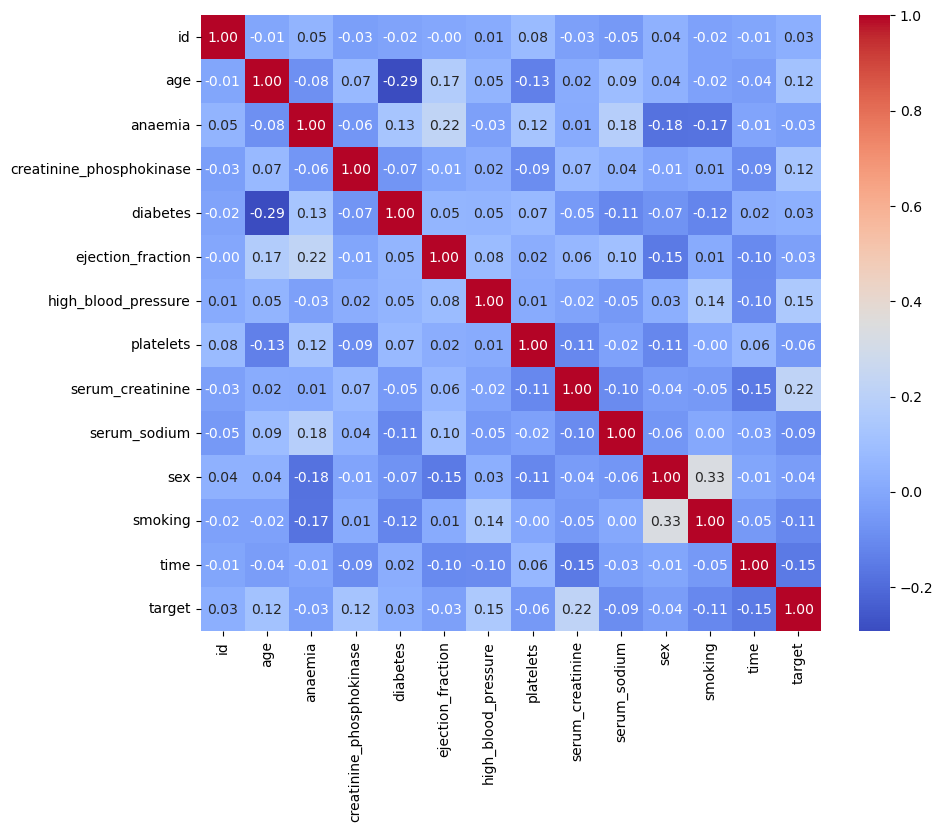

In [4]:
# Calculate the correlation matrix
corr_matrix = train_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [5]:
# Set a correlation threshold 
correlation_threshold = 0.08

# Find features with low correlation to the target variable
correlated_features = corr_matrix.index[abs(corr_matrix['target']) < correlation_threshold]

# Remove these features from the dataset
train_df_reduced = train_df.drop(columns=correlated_features)

# Print the removed features and the number of remaining features
print(f"Removed features with low correlation with the target: {list(correlated_features)}")
print(f"Number of features after removal: {train_df_reduced.shape[1]}")

Removed features with low correlation with the target: ['id', 'anaemia', 'diabetes', 'ejection_fraction', 'platelets', 'sex']
Number of features after removal: 8


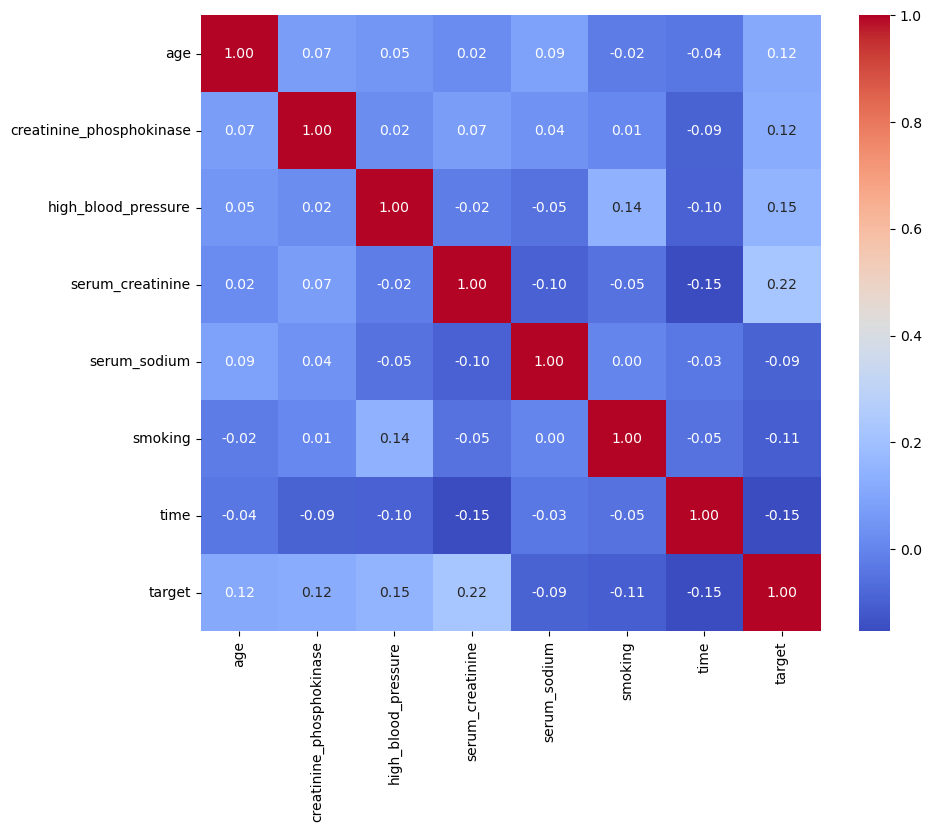

In [6]:
# Calculate the correlation matrix
corr_matrix = train_df_reduced.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [7]:
train_df = train_df_reduced

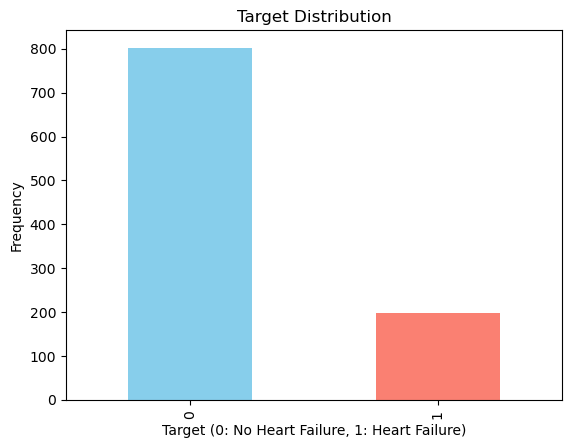

target
0    802
1    198
Name: count, dtype: int64


In [8]:
# Plot the distribution of the target variable
train_df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution')
plt.ylabel('Frequency')
plt.xlabel('Target (0: No Heart Failure, 1: Heart Failure)')
plt.show()
print(train_df['target'].value_counts())

# The target distribution shows a clear imbalance, with a significant majority of 0's (No Heart Failure).

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [10]:
# Scaling the data (standardization)
# Standardize all numerical features except 'id' and 'target'
scaler = StandardScaler()
numerical_features = train_df.select_dtypes(include=[np.number]).columns

# Exclude 'id' and 'target' from scaling
numerical_features = numerical_features[numerical_features != 'id']
numerical_features = numerical_features[numerical_features != 'target']

# Scale the data
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])

# Balancing the classes
# Check the distribution of the target variable
print(train_df['target'].value_counts())

target
0    802
1    198
Name: count, dtype: int64


In [11]:
# Since class 0 is significantly larger, apply oversampling to class 1 (using resample)
# This is a simple approach for balancing the classes

# Split the data into two classes
class_0 = train_df[train_df['target'] == 0]
class_1 = train_df[train_df['target'] == 1]

# Upsample class 1 to match the size of class 0
class_1_upsampled = resample(class_1, 
                              replace=True,    # Allow repeated selection
                              n_samples=len(class_0),  # To match the size of class 0
                              random_state=42)  # For reproducibility

# Combine the classes back together
train_df_balanced = pd.concat([class_0, class_1_upsampled])

# Shuffle the data to avoid any ordering
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(train_df_balanced['target'].value_counts())

target
0    802
1    802
Name: count, dtype: int64


In [12]:
# Split the data into features and target variable
X = train_df_balanced.drop(columns=['target'])
y = train_df_balanced['target']

# Split the data into training and test sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

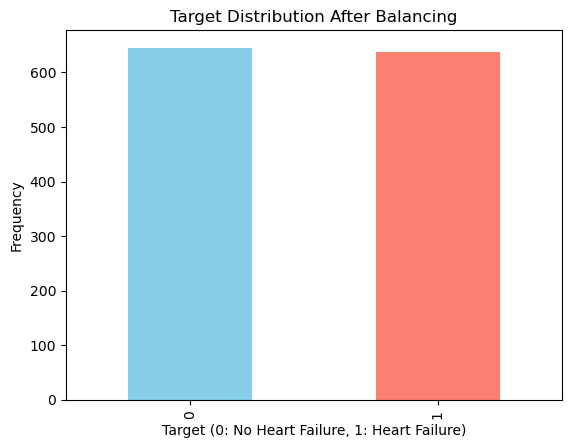

In [28]:
# Visualize the distribution of the target variable after balancing
y_train.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution After Balancing')
plt.ylabel('Frequency')
plt.xlabel('Target (0: No Heart Failure, 1: Heart Failure)')
plt.show()

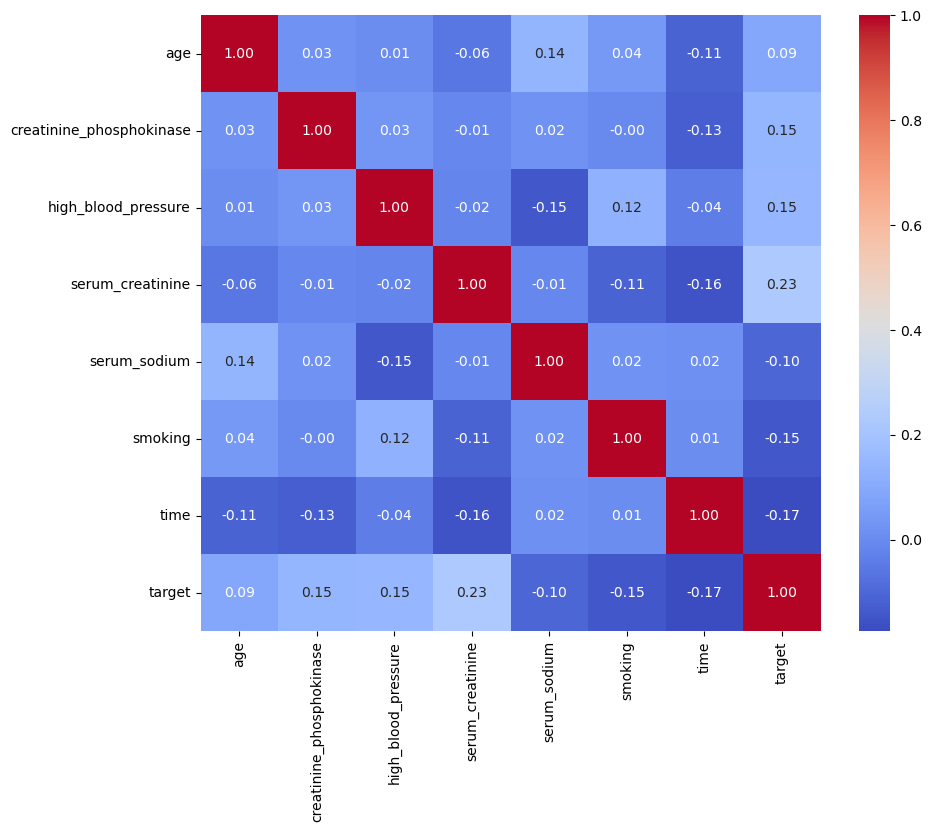

In [14]:
# Calculate the correlation matrix
corr_matrix = train_df_balanced.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

In [96]:
#!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s eta 0:00:0000:0100:01


# Stacking model

In [18]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Create base models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
gb_model = GradientBoostingClassifier(random_state=42)

# 2. Create the meta-model (logistic regression)
meta_model = LogisticRegression()

# 3. Create the Stacking model
stacking_model = StackingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('gb', gb_model)],  # Base models
    final_estimator=meta_model,  # Meta-model
)

# 4. Train the ensemble model on the training data
stacking_model.fit(X_train, y_train)

# 5. Make predictions on the test data
y_pred_stacking = stacking_model.predict(X_test)

# 6. Evaluate accuracy
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Model Accuracy: {accuracy_stacking:.4f}")

# 7. Detailed classification report (precision, recall, f1-score)
print("\nStacking Model Classification Report:")
print(classification_report(y_test, y_pred_stacking))


/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bs

Stacking Model Accuracy: 0.9626

Stacking Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       157
           1       0.95      0.98      0.96       164

    accuracy                           0.96       321
   macro avg       0.96      0.96      0.96       321
weighted avg       0.96      0.96      0.96       321



# Cat boost

In [16]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Создание модели CatBoost
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=7, random_state=42, verbose=100)

# 2. Обучение модели на тренировочных данных
catboost_model.fit(X_train, y_train)

# 3. Сделать предсказания на тестовых данных
y_pred_catboost = catboost_model.predict(X_test)

# 4. Оценка точности
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"CatBoost Accuracy: {accuracy_catboost:.4f}")

# 5. Detailed classification report (precision, recall, f1-score)
print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred_catboost))

0:	learn: 0.6741004	total: 59.7ms	remaining: 59.6s
100:	learn: 0.2142371	total: 144ms	remaining: 1.28s
200:	learn: 0.1223175	total: 227ms	remaining: 901ms
300:	learn: 0.0755060	total: 327ms	remaining: 760ms
400:	learn: 0.0505818	total: 409ms	remaining: 611ms
500:	learn: 0.0361956	total: 492ms	remaining: 490ms
600:	learn: 0.0292050	total: 575ms	remaining: 382ms
700:	learn: 0.0226213	total: 658ms	remaining: 281ms
800:	learn: 0.0189307	total: 741ms	remaining: 184ms
900:	learn: 0.0161180	total: 824ms	remaining: 90.6ms
999:	learn: 0.0140200	total: 908ms	remaining: 0us
CatBoost Accuracy: 0.9315

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       157
           1       0.90      0.98      0.94       164

    accuracy                           0.93       321
   macro avg       0.94      0.93      0.93       321
weighted avg       0.93      0.93      0.93       321



In [47]:
test_df = pd.read_csv('test.csv')
# 6. Получение вероятностей для дальнейшего анализа (например, для выбора 219 больных)
y_pred_prob_catboost = catboost_model.predict_proba(test_df.drop(columns=['id', 'anaemia', 'diabetes', 'ejection_fraction', 'platelets', 'sex']))[:, 1]  # Вероятности для класса 1

# 7. Сортируем и выбираем 219 с наибольшими вероятностями
indices_sorted_catboost = np.argsort(y_pred_prob_catboost)[::-1]
top_219_indices_catboost = indices_sorted_catboost[:219]

# 8. Создаем финальные предсказания
final_predictions_catboost = np.zeros(len(y_pred_prob_catboost))
final_predictions_catboost[top_219_indices_catboost] = 1

In [56]:
final_predictions_catboost = final_predictions_catboost.astype(int)

In [62]:
final_predictions_catboost_df = pd.DataFrame({
    'id': test_df['id'], 
    'target': final_predictions_catboost 
})

,id,target
0,1,0
1,2,0
2,4,0
3,5,1
4,6,0
...,...,...
995,1992,0
996,1993,0
997,1995,0
998,1997,0


In [63]:
final_predictions_catboost_df.to_csv('results/submission_drop_low_corr_catboost_219.csv', header=False, index=False)

# Result saving

In [22]:
test_df = pd.read_csv('test.csv')
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

y_pred_test = catboost_model.predict(test_df.drop(columns=['id', 'anaemia', 'diabetes', 'ejection_fraction', 'platelets', 'sex']))
positives = (y_pred_test == 1).sum()

print(f"Number of positive answers: {positives}")

Number of positive answers: 195


In [23]:
submission_df = pd.DataFrame({
    'id': test_df['id'],  
    'target': y_pred_test 
})
submission_df.to_csv('results/submission_drop_low_corr_catboost.csv', header=False, index=False)

In [72]:
# calculating difference with previous submission
submission = pd.read_csv('results/submission_drop_low_corr_catboost_219.csv', header=None)
submission1 = pd.read_csv('results/submission_drop_low_corr_catboost.csv', header=None)


differences = (submission[1] != submission1[1]).sum()

print(f"Number of differing answers: {differences}")

positives = (submission[1] == 1).sum()

print(f"Number of positive answers: {positives}")

Number of differing answers: 308
Number of positive answers: 219


In [71]:
# 1. Загружаем результаты из файлов
submission = pd.read_csv('results/submission_drop_low_corr_catboost.csv', header=None)
submission1 = pd.read_csv('results/submission_drop_low_corr_catboost_219.csv', header=None)

# 2. Инициализация переменных для подсчета различий
differences = 0
mismatches = []

# 3. Проходим по каждому случаю и сравниваем ответы
for i in range(len(submission)):
    if submission[1][i] != submission1[1][i]:
        differences += 1
        # Добавляем в список не совпавших ответов, указывая какие модели как ответили
        mismatches.append({
            "Index": i,
            "CatBoost Prediction": submission[1][i],
            "219 Prediction": submission1[1][i]
        })

# 4. Выводим количество различий
print(f"Number of differing answers: {differences}")

# 5. Выводим подробности о каждом несовпадении
if differences > 0:
    print("\nDetailed Mismatches:")
    for mismatch in mismatches:
        print(f"Index {mismatch['Index']} - CatBoost: {mismatch['CatBoost Prediction']} vs 219: {mismatch['219 Prediction']}")


Number of differing answers: 308

Detailed Mismatches:
Index 1 - CatBoost: 1 vs 219: 0
Index 2 - CatBoost: 1 vs 219: 0
Index 3 - CatBoost: 0 vs 219: 1
Index 6 - CatBoost: 1 vs 219: 0
Index 7 - CatBoost: 1 vs 219: 0
Index 8 - CatBoost: 0 vs 219: 1
Index 15 - CatBoost: 1 vs 219: 0
Index 22 - CatBoost: 0 vs 219: 1
Index 26 - CatBoost: 1 vs 219: 0
Index 27 - CatBoost: 1 vs 219: 0
Index 31 - CatBoost: 0 vs 219: 1
Index 35 - CatBoost: 1 vs 219: 0
Index 37 - CatBoost: 0 vs 219: 1
Index 41 - CatBoost: 1 vs 219: 0
Index 42 - CatBoost: 0 vs 219: 1
Index 43 - CatBoost: 1 vs 219: 0
Index 44 - CatBoost: 0 vs 219: 1
Index 55 - CatBoost: 0 vs 219: 1
Index 61 - CatBoost: 0 vs 219: 1
Index 62 - CatBoost: 0 vs 219: 1
Index 63 - CatBoost: 0 vs 219: 1
Index 64 - CatBoost: 1 vs 219: 0
Index 71 - CatBoost: 1 vs 219: 0
Index 76 - CatBoost: 1 vs 219: 0
Index 78 - CatBoost: 0 vs 219: 1
Index 80 - CatBoost: 1 vs 219: 0
Index 84 - CatBoost: 1 vs 219: 0
Index 85 - CatBoost: 1 vs 219: 0
Index 86 - CatBoost: 1 vs 2

In [36]:
# calculating number of 1's in test prediction
# calculating difference with previous submission
submission = pd.read_csv('results/submission_drop_low_corr_stacking_v1.csv', header=None)


positives = (submission1[1] == 1).sum()

print(f"Number of positive answers: {positives}")


Number of positive answers: 145


In [ ]:
import numpy as np
# 1. Получаем вероятности для класса 1 (больные) с использованием predict_proba
y_pred_prob = stacking_model.predict_proba(X_test)[:, 1]

# 2. Сортируем индексы по вероятности (от большего к меньшему)
indices_sorted = np.argsort(y_pred_prob)[::-1]  # Сортируем в обратном порядке

# 3. Выбираем 219 пациентов с наибольшими вероятностями
top_219_indices = indices_sorted[:219]

# 4. Создаем массив с метками, где 1 означает, что пациент выбран
final_predictions = np.zeros(len(y_pred_prob))
final_predictions[top_219_indices] = 1

# 5. Оценка качества предсказания
# Проверяем, сколько из выбранных 219 пациентов действительно больны
true_labels = y_test.values  # Истинные метки на тестовых данных
correct_predictions = np.sum(true_labels[top_219_indices] == 1)  # Сколько из выбранных больных

accuracy = correct_predictions / 219  # Доля правильно предсказанных больных среди выбранных
print(f"Accuracy: {accuracy:.4f}")
